In [2]:
#Define functions (Always run)

import pandas as pd
import numpy as np
from os import listdir

#Import the data from the file
def read_data(filename):
    #Open file and read all first 11 lines
    data = open(filename)
    text = ''
    params = {}

    params1 = ['metric','fType']
    for i in range(2):
        row   = data.readline()
        text += row
        params.update({params1[i]:row.split(':')[1][1:-1]})
    params2 = ['p0','r0','d','Kreiss-Oliger','deltaR']
    for i in range(5):
        row   = data.readline()
        text += row
        params.update({params2[i]:float(row.split(':')[1])})
    params3 = ['maxR','iterations','nP','time']
    for i in range(4):
        row   = data.readline()
        text += row
        params.update({params3[i]:int(row.split(':')[1])})
    params.update({'text':text})
    #Read data for R, phi, Phi and Pi
    rdata = list(map(float,(data.readline().split(','))[:-1]))
    alldata = data.readlines()
    data.close()
    len_5 = int(len(alldata)/5)
    if(len_5*5 !=len(alldata)):
        raise ValueError

    for i in range(5*len_5):
        alldata[i] = list(map(float,(alldata[i].replace('-nan(ind)','nan').split(','))[:-1]))
    fdata = np.array(alldata[:len_5])
    xdata = np.array(alldata[len_5:2*len_5])
    ydata = np.array(alldata[2*len_5:3*len_5])
    if(params['metric'].startswith('Modified Choptuik')):
        grdata = (np.array(alldata[3*len_5:4*len_5]))**2
        g0data = (np.array(alldata[4*len_5:]))**2
    else:
        grdata = (np.array(alldata[3*len_5:4*len_5]))**(-2)
        g0data = (np.array(alldata[4*len_5:]))**(-2)

    return rdata, fdata, xdata, ydata, grdata, g0data, params

def read_binaries(a_bin='A.bin',Phi_bin='Phi.bin',R_bin='R.bin'):
    params = {'text':'text pending'}
    with open(Phi_bin,'rb') as file:
        xdata = np.fromfile(file, dtype=np.float64)
    with open(a_bin,'rb') as file:
        grdata = np.fromfile(file, dtype=np.float64)**(-2)
    with open(R_bin,'rb') as file:
        rdata = np.fromfile(file, dtype=np.float64)
    iterations = int(len(xdata)/len(rdata))
    xdata = xdata.reshape((iterations,len(rdata)))
    grdata = grdata.reshape((iterations,len(rdata)))
    fdata = np.zeros_like(xdata)
    ydata = np.zeros_like(xdata)
    g0data = np.zeros_like(xdata)
    fdata[0] = 1
    return rdata, fdata, xdata, ydata, grdata, g0data, params
import matplotlib.animation as animation
import matplotlib.pyplot as plt

#Animation in paralel of scalar fields
def animate_data(filename, ipf = 1,output_name = None,ls='-',marker='',ms=0.5,ftype='dat'):
    if ftype=='dat':
        r,f,x,y,gr,g0,params = read_data(filename)
    elif ftype=='bin':
        r,f,x,y,gr,g0,params = read_binaries()
    else:
        raise ValueError

    plt.ioff()
    IPF = ipf #Iterations per frame
    iterations = len(f)
    if ipf>iterations:
        raise ValueError
    FRAMES = int(iterations/IPF)

    fig, ax = plt.subplots(3,2,figsize=(12,12),dpi=120)

    Fplot = ax[0,0].plot(r,f[0] ,ls=ls,marker=marker,markersize=ms)[0]
    Xplot = ax[1,0].plot(r,x[0] ,ls=ls,marker=marker,markersize=ms)[0]
    Yplot = ax[2,0].plot(r,y[0] ,ls=ls,marker=marker,markersize=ms)[0]
    Aplot = ax[1,1].plot(r,gr[0],ls=ls,marker=marker,markersize=ms)[0]
    Bplot = ax[2,1].plot(r,g0[0],ls=ls,marker=marker,markersize=ms)[0]
    ax[0,0].text(1.21,0.98,params['text'],verticalalignment='top',transform=ax[0,0].transAxes)
    ax[0,1].remove()
    ax[1,0].set_ylim( -ax[0,0].get_ylim()[1],ax[0,0].get_ylim()[1])
    ax[2,0].set_ylim(  ax[0,0].get_ylim())
    ax[1,1].set_ylim(-0.1,1.1)
    ax[2,1].set_ylim(-0.1,1.1)
    #Make limits for phi plot based on maximum initial difference from external point
    try:
        deltaLim = max(f[0][-1] -ax[0,0].get_ylim()[0], ax[0,0].get_ylim()[1] -f[0][-1])
        ax[0,0].set_ylim(f[0][-1]-deltaLim,f[0][-1]+deltaLim)
    except:
        None
    ax[0,0].set_title('$\phi$')
    ax[1,0].set_title('$\Phi$')
    ax[2,0].set_title('$\Pi$')
    ax[1,1].set_title('$g^{rr}$')
    ax[2,1].set_title('$g^{00}$')

    #Create a function that changes the data every frame
    def animate(i):
        it = i*IPF
        Fplot.set_data(r,f[it])
        Xplot.set_data(r,x[it])
        Yplot.set_data(r,y[it])
        Aplot.set_data(r,gr[it])
        Bplot.set_data(r,g0[it])
        return None

    #Make the animation
    anim = animation.FuncAnimation(fig, animate, frames=FRAMES,
                                    interval=100, repeat_delay=3000)
    if (output_name == None):
        output_name = filename[:-3]+'gif'
    anim.save(output_name,writer='pillow')
    plt.close()


def plot_last(filename, diff_from_collapse=-1, replace_nan=-1):
    r,f,x,y,gr,g0,params = read_data(filename)


    iterations = len(f)

    #Find the last iteration before collapse
    last_iteration = iterations-1
    for i in range(iterations):
        f_nan  = np.any(np.isnan( f[i]))
        #f_nan  = False
        x_nan  = np.any(np.isnan( x[i]))
        y_nan  = np.any(np.isnan( y[i]))
        gr_nan = np.any(np.isnan(gr[i]))
        g0_nan = np.any(np.isnan(g0[i]))
        if np.any((f_nan,x_nan,y_nan,gr_nan,g0_nan)):
            last_iteration = i+diff_from_collapse
            break

    fig, ax = plt.subplots(3,2,figsize=(12,12),dpi=100)

    ax[0,0].plot(r,np.nan_to_num( f[last_iteration],nan=replace_nan))[0]
    ax[1,0].plot(r,np.nan_to_num( x[last_iteration],nan=replace_nan))[0]
    ax[2,0].plot(r,np.nan_to_num( y[last_iteration],nan=replace_nan))[0]
    ax[1,1].plot(r,np.nan_to_num(gr[last_iteration],nan=replace_nan))[0]
    ax[2,1].plot(r,np.nan_to_num(g0[last_iteration],nan=replace_nan))[0]
    ax[0,0].text(1.21,0.98,params['text']+f'\nPrinted iteration: {last_iteration}',verticalalignment='top',transform=ax[0,0].transAxes)
    ax[0,1].remove()
    #ax[1,1].set_ylim(-0.1,1.1)
    #ax[2,1].set_ylim(-0.1,1.1)
    ax[0,0].set_title('$\phi$')
    ax[1,0].set_title('$\Phi$')
    ax[2,0].set_title('$\Pi$')
    ax[1,1].set_title('$g^{rr}$')
    ax[2,1].set_title('$g^{00}$')

    plt.show()

#Animation in paralel of scalar fields
def animate_multiple(filenames, ipf = 1,output_name = None,ls='-',marker='',ms=0.5):
    Nfiles = len(filenames)
    r= []
    x= []
    params= []
    for iN,file in enumerate(filenames):
        r_,f_,x_,y_,gr_,g0_,params_ = read_data(file)
        r.append(r_)
        x.append(x_)
        params.append(params_)
    #r,f,x,y,gr,g0,params = read_binaries()

    plt.ioff()
    IPF = ipf #Iterations per frame
    iterations = len(x[0])
    if ipf>iterations:
        raise ValueError
    FRAMES = int(iterations/IPF)

    fig, ax = plt.subplots(Nfiles,1,figsize=(10,Nfiles*2),dpi=120)
    Xplot = []
    for iN in range(Nfiles):
        Xplot.append(ax[iN].plot(r[iN],x[iN][0] ,ls=ls,marker=marker,markersize=ms)[0])
        #ax[iN].text(1.21,0.98,params[iN]['text'],verticalalignment='top',transform=ax[iN].transAxes)
        ax[iN].set_title(f'$\Phi$\tKO coeff = {params[iN]["Kreiss-Oliger"]}')
    fig.tight_layout()

    #Create a function that changes the data every frame
    def animate(i):
        it = i*IPF
        for iN in range(Nfiles):
            Xplot[iN].set_data(r[iN],x[iN][it])
        return None

    #Make the animation
    anim = animation.FuncAnimation(fig, animate, frames=FRAMES,
                                    interval=100, repeat_delay=3000)
    if (output_name == None):
        output_name = 'Multi_anim.gif'
    anim.save(output_name,writer='pillow')
    plt.close()
        


In [8]:
#Animate data from binary files (python)
animate_data('python.dat',1,ftype='bin')

In [23]:
#Arbitrary run

import subprocess
import numpy as np

fType = "1"
r0 = "0"
d  = "0"
KOs  = ["0.0","0.03","0.05"]
deltaR = '0.01'
maxR = "100"
iterations = "4000"
processes = "1"
p0 = '0.000008'

for ko in KOs:
    output = subprocess.check_output([".\Collapse.exe",  fType, p0, r0, d, ko, deltaR, maxR, iterations, processes], text=True,)
    print(f"{output}")

Total iterations: 4000
Finished, total time: 1s

Total iterations: 4000
Finished, total time: 1s

Total iterations: 4000
Finished, total time: 1s



In [9]:
#Animate a file
dat_files = listdir()
dat_files = [f for f in dat_files if f.endswith('.dat')]
print('Índice  Nombre')
for i in range(len(dat_files)):
    print(f'{i}       {dat_files[i]}')
inlist_dat= input("Ingrese el índice o nombre del archivo que desea graficar: ")
if not inlist_dat.endswith('.dat'):
    inlist_dat = dat_files[int(inlist_dat)]

print(f'Graficando {inlist_dat} ...')
animate_data(inlist_dat,20,ls='',marker='.',ms=1)
print(f'Animación de {inlist_dat} lista')
#plot_last(inlist_dat,0)

Índice  Nombre
0       Output_162115.dat
1       Output_163142.dat
2       Output_164344.dat


KeyboardInterrupt: Interrupted by user

In [4]:
files = ["Output_121137.dat","Output_200711.dat","Output_201752.dat","Output_122236.dat","Output_123339.dat","Output_222817.dat","Output_213858.dat"]
animate_multiple(files,ipf=1,ls='',marker='.',ms=1)

In [22]:
#Animate all files
from os import listdir
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
for file in folder_files:
        animate_data(file,ipf=5,ls='',marker='.',ms=1)
        print(f'Animation for {file} ready')

Animation for Output_185734.dat ready
Animation for Output_185735.dat ready
Animation for Output_185737.dat ready


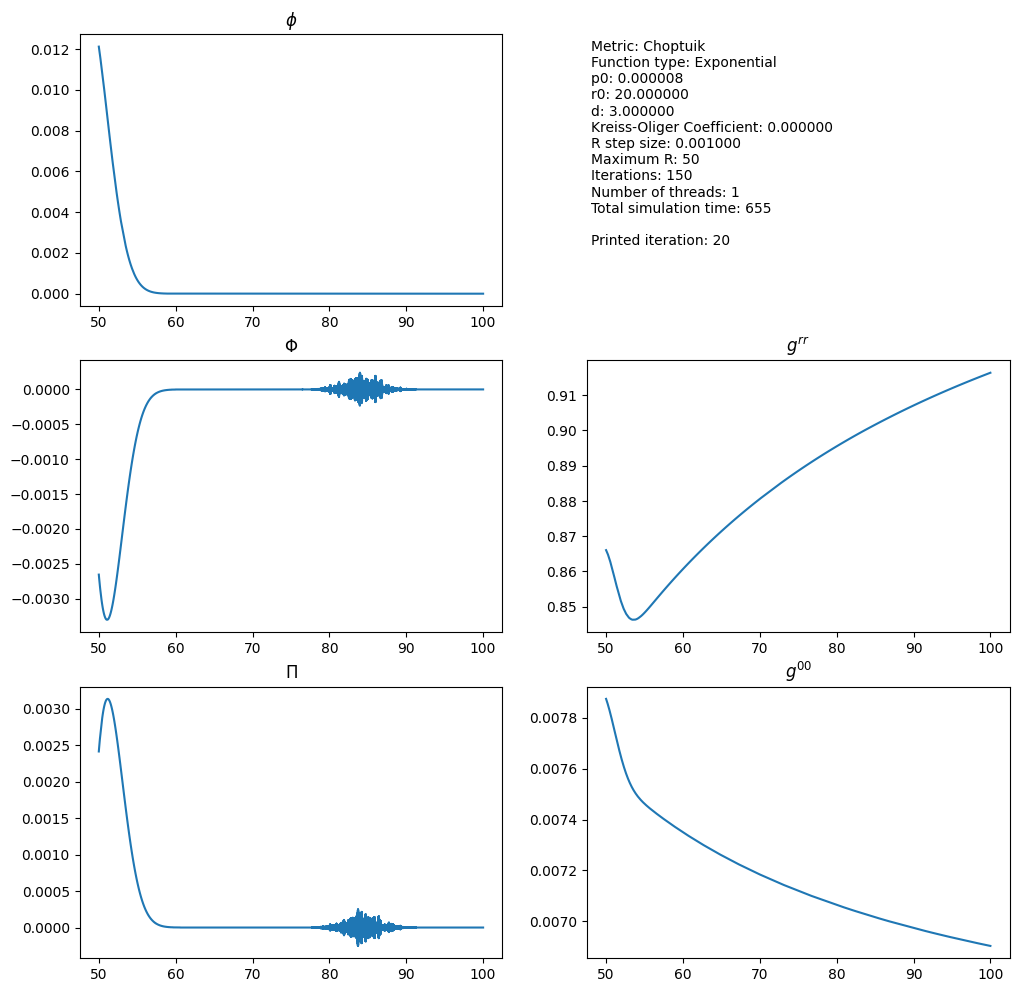

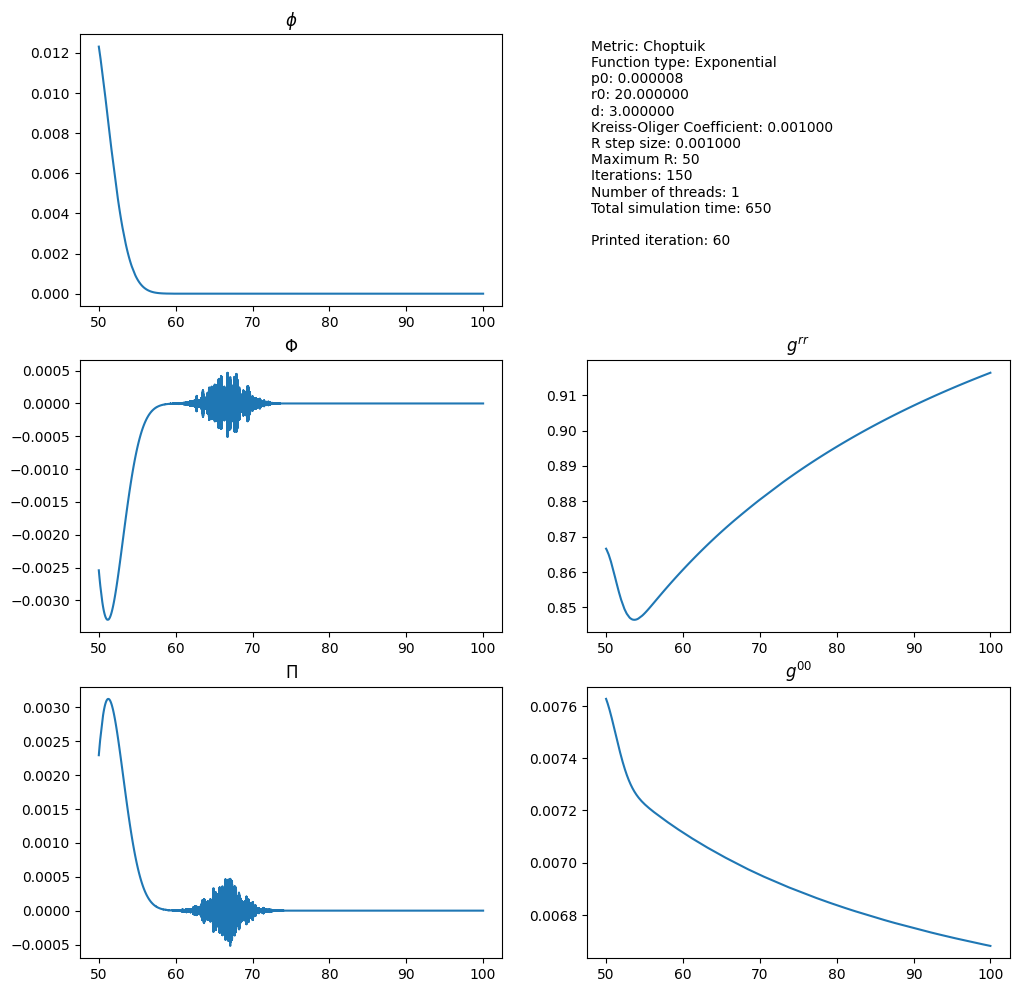

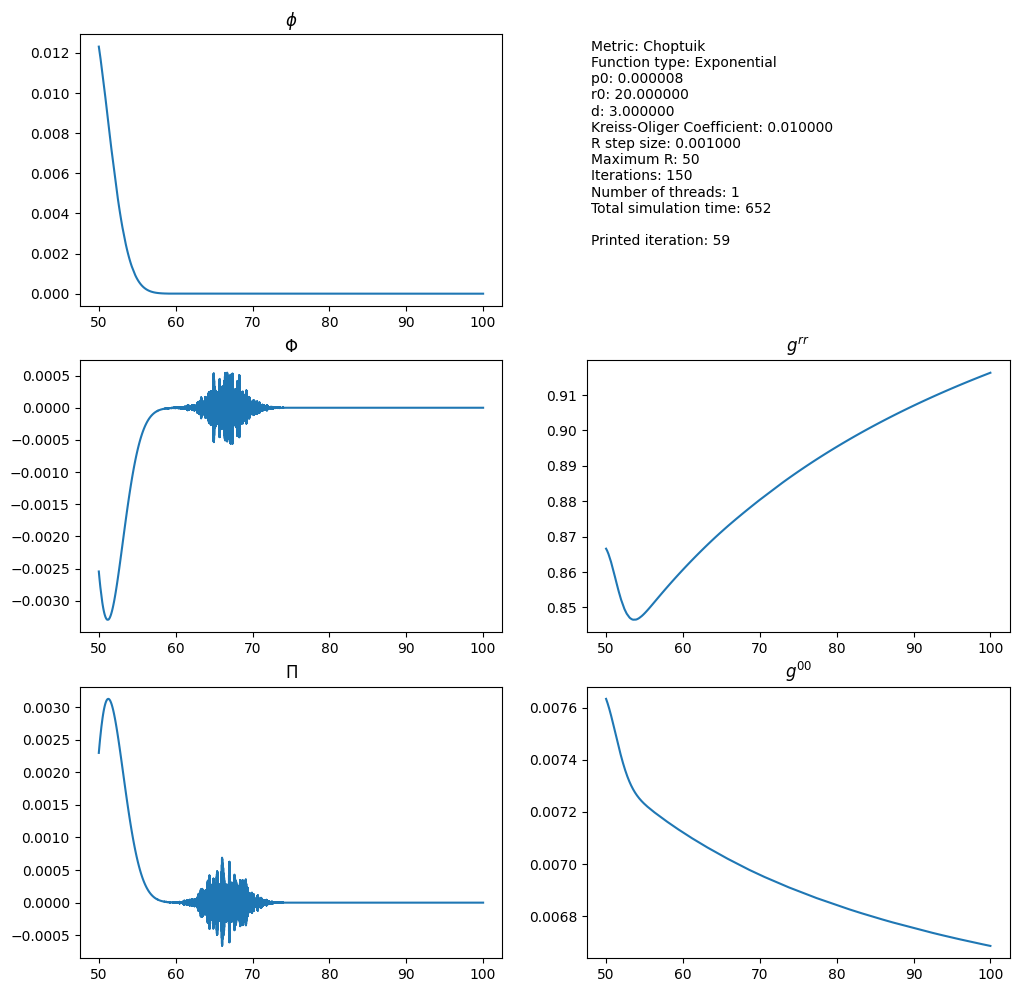

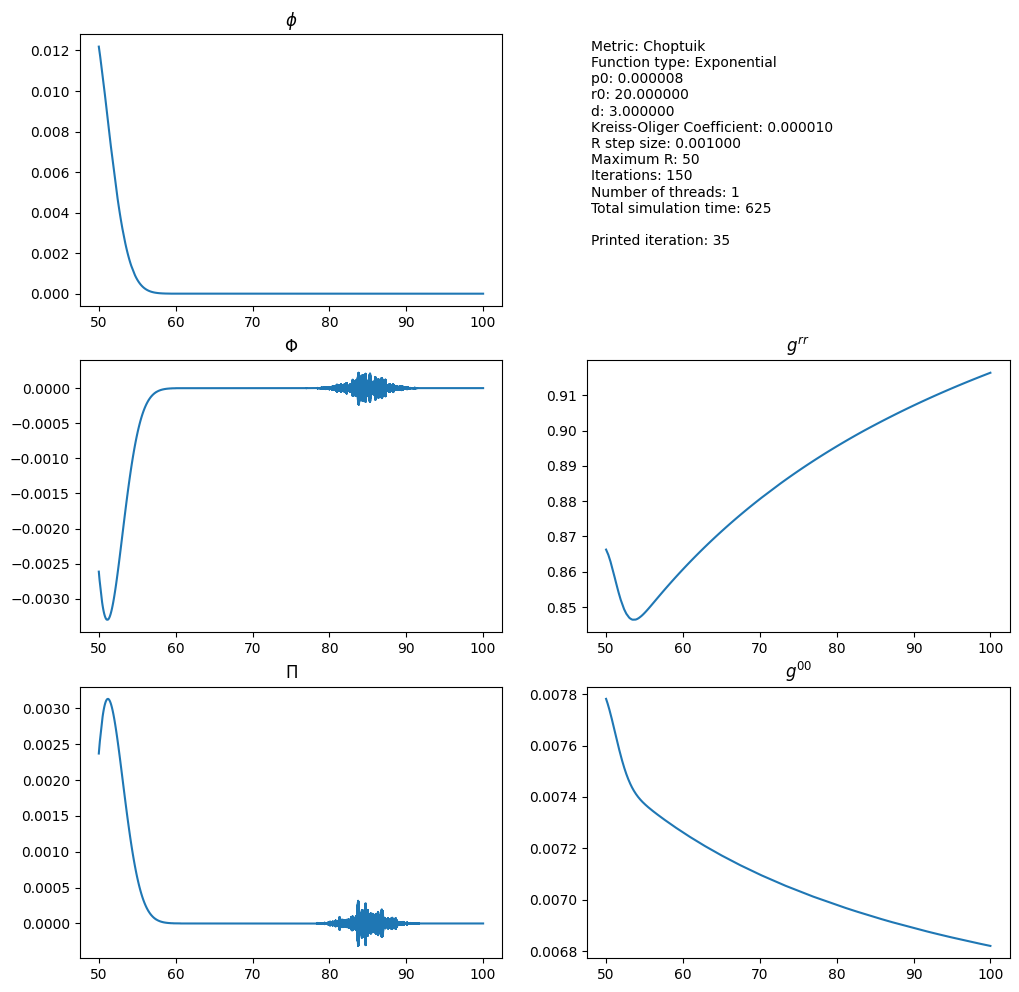

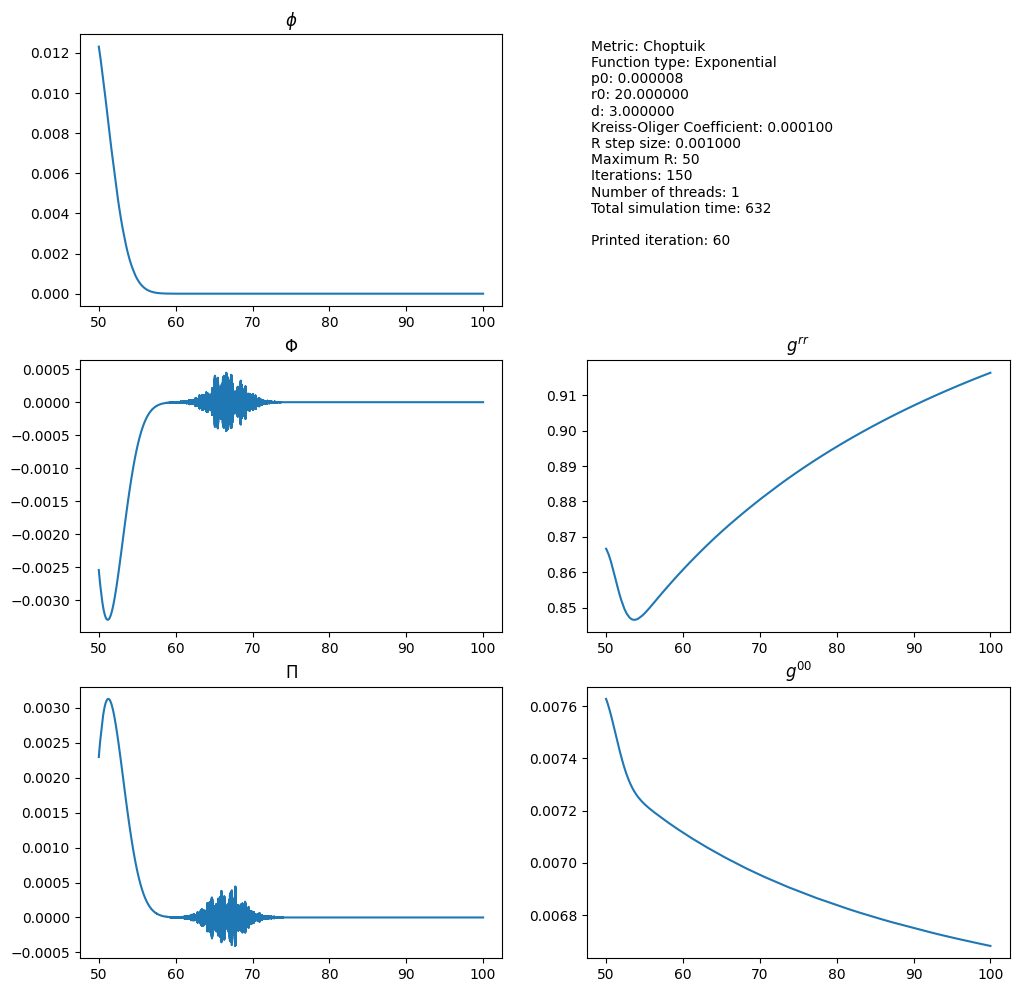

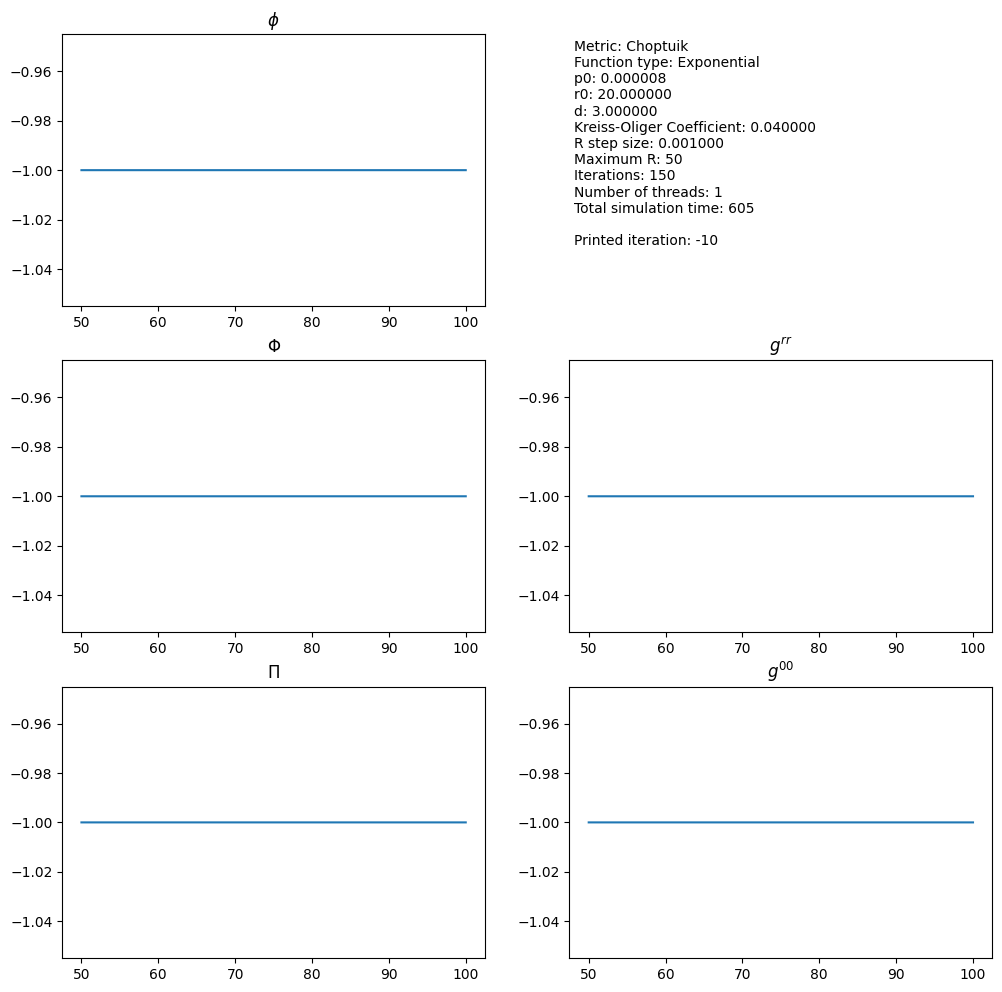

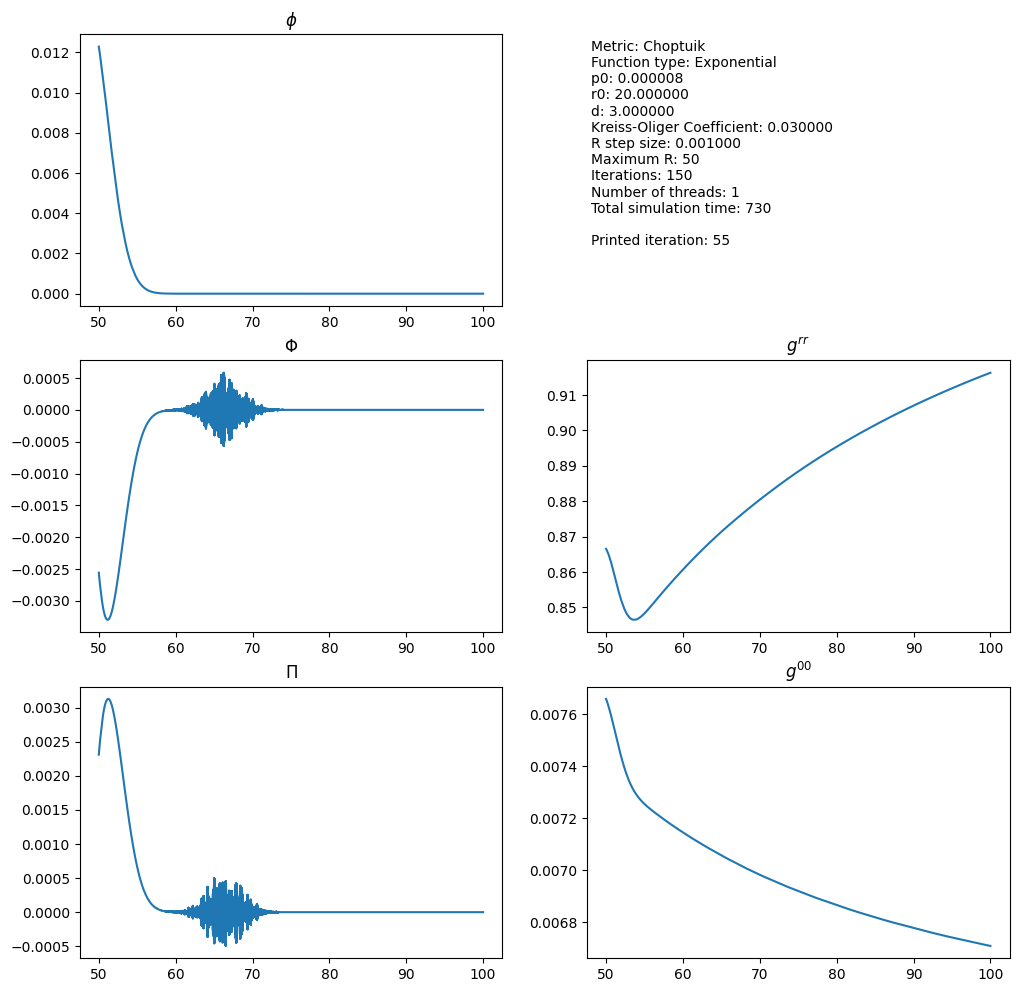

In [25]:
#Plot last frame of all files
from os import listdir
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
for file in folder_files:
        plot_last(file,-10)

## Parallelization performance

In [ ]:
#Parallel run

import subprocess
import time

fType = "0"
p0 = "0"
r0 = "0"
d  = "0"
q  = "0"
iterations = "20000"
maxR = "70"
processes = ["1","2","3","4","5","6","7","8","9","10","11","12"]
for p in processes:
    try:
        output = subprocess.check_output([".\Collapse.exe", fType, p0, r0, d, q, maxR, iterations, p], text=True,)
        print(f"Parallel execution:\n{output}")
    except subprocess.CalledProcessError as e:
        print(f"Parallel execution (supposedly an error):\n{e.output}")

In [8]:
#Read the last runs and compare performance
import pandas as pd
from os import listdir

#Search files
df = pd.DataFrame(columns=('Metric','Threads','Time','Iterations'))
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
for file in folder_files:
    params = read_data(file)[4]
    new_row = pd.DataFrame([[params['metric'],params['nP'],params['time'],params['iterations']]],columns=('Metric','Threads','Time','Iterations'))
    df = pd.concat((df, new_row), ignore_index=True)

In [9]:
df

,Metric,Threads,Time,Iterations
0,Choptuik,1,182,20000
1,Choptuik,2,147,20000
2,Choptuik,3,139,20000
3,Choptuik,4,137,20000
4,Choptuik,5,133,20000
5,Choptuik,6,135,20000
6,Choptuik,7,135,20000
7,Choptuik,8,135,20000
8,Choptuik,9,134,20000
9,Choptuik,10,133,20000


## Test on different parameters

In [26]:
#Run for tanh function

import subprocess
import numpy as np

fType = "0"
p0s = np.linspace(0.04,0.08,6)
r0 = "0"
d  = "0"
q  = "0"
iterations = "30000"
maxR = "50"
processes = "0"
for p0 in p0s:
    output = subprocess.check_output([".\Collapse.exe", fType, str(p0), r0, d, q, maxR, iterations, processes], text=True,)
    print(f"{output}")

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished



In [3]:
animate_data('Output_202803.dat',ipf=500)

FileNotFoundError: [Errno 2] No such file or directory: 'Output_202803.dat'

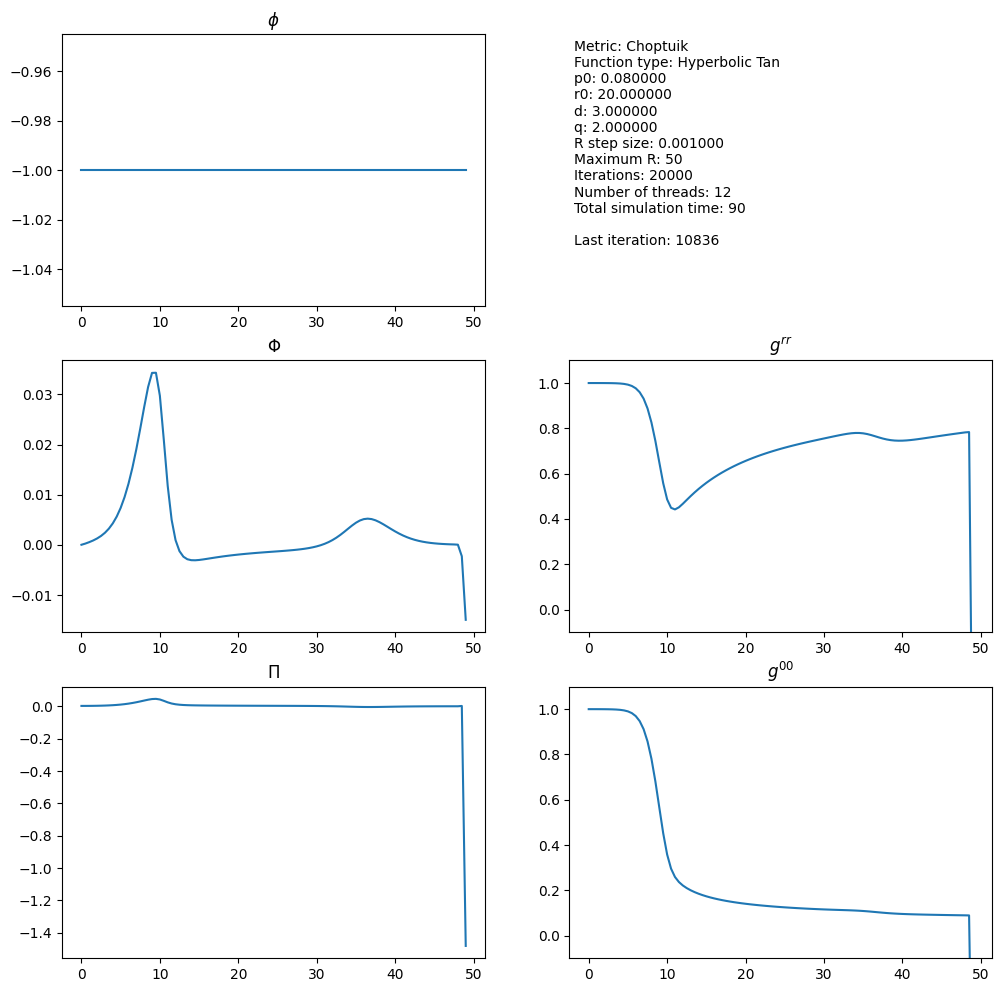

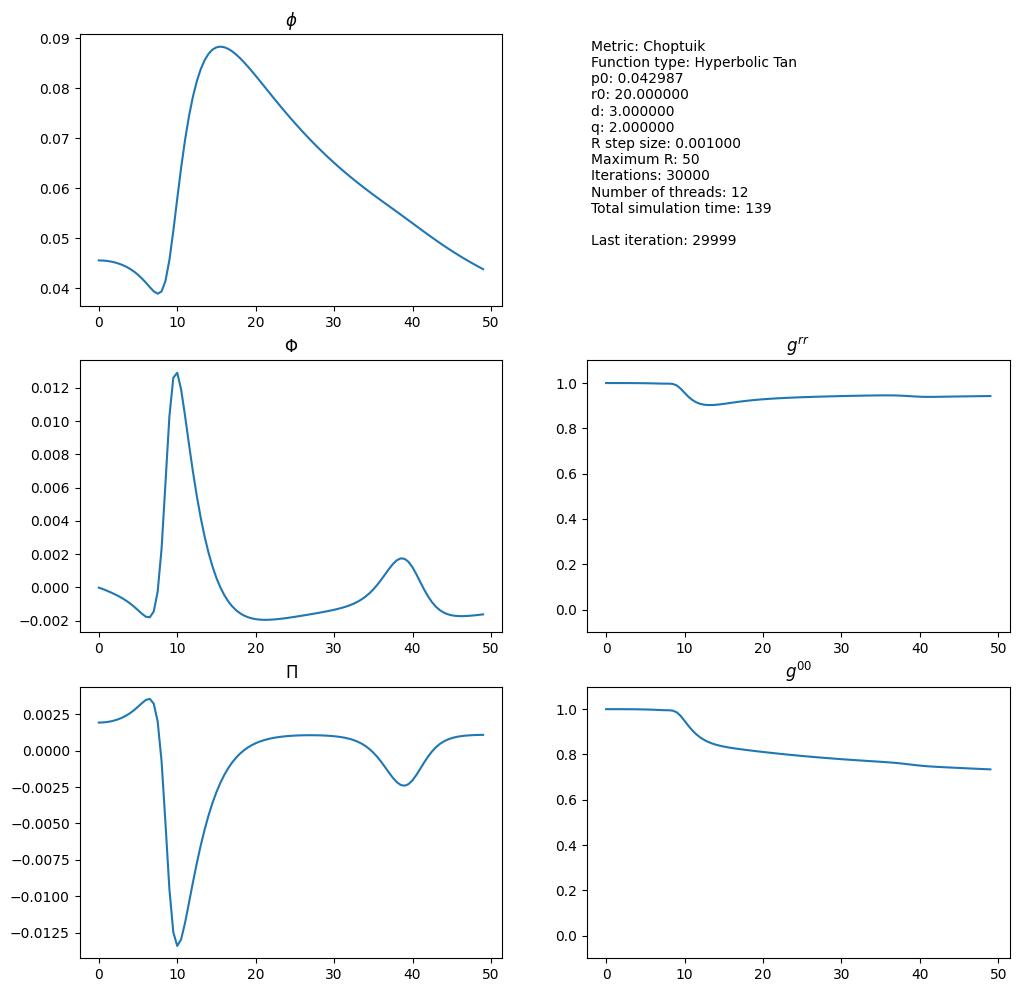

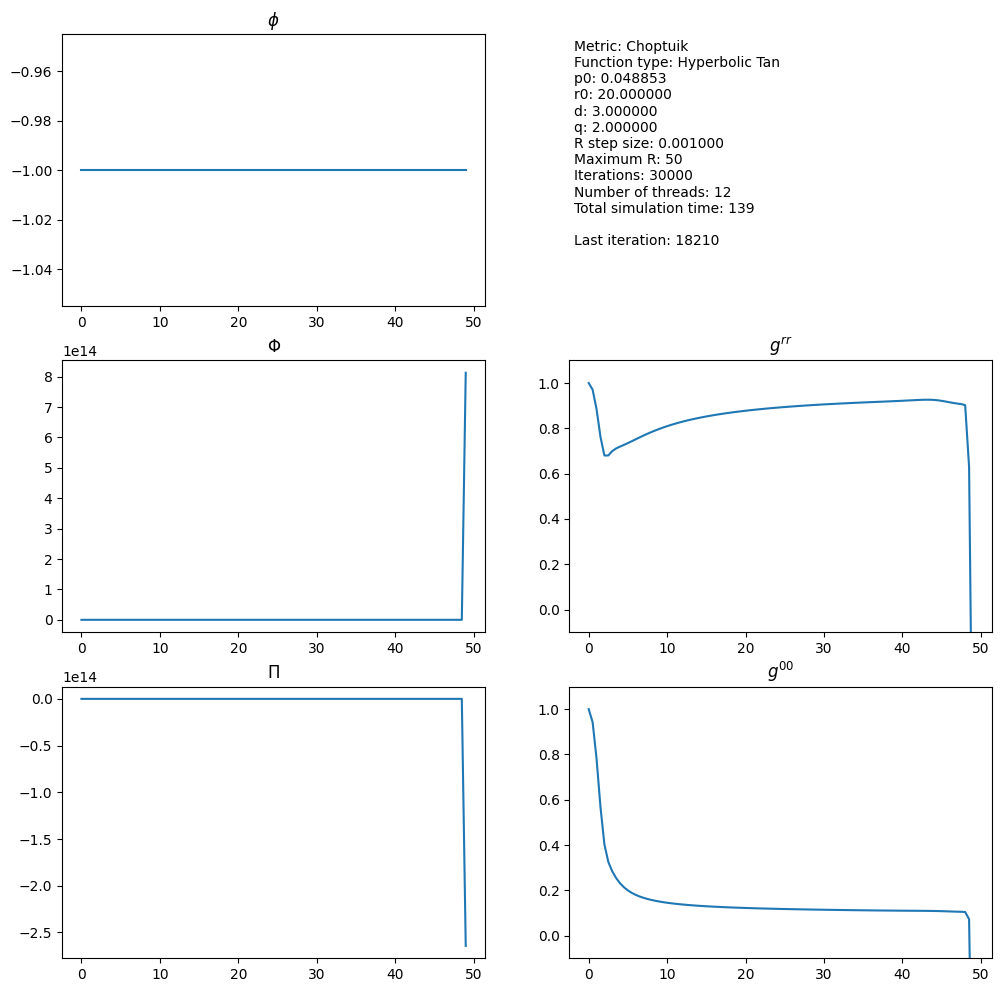

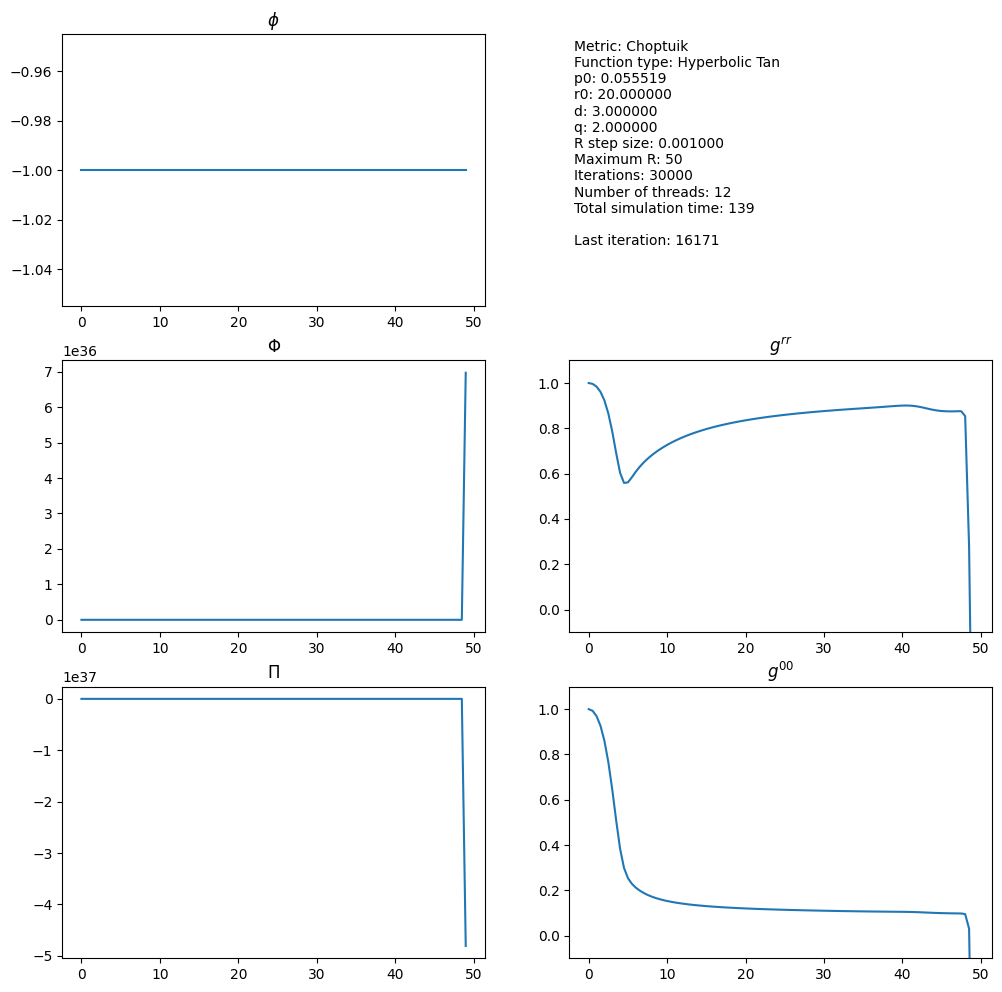

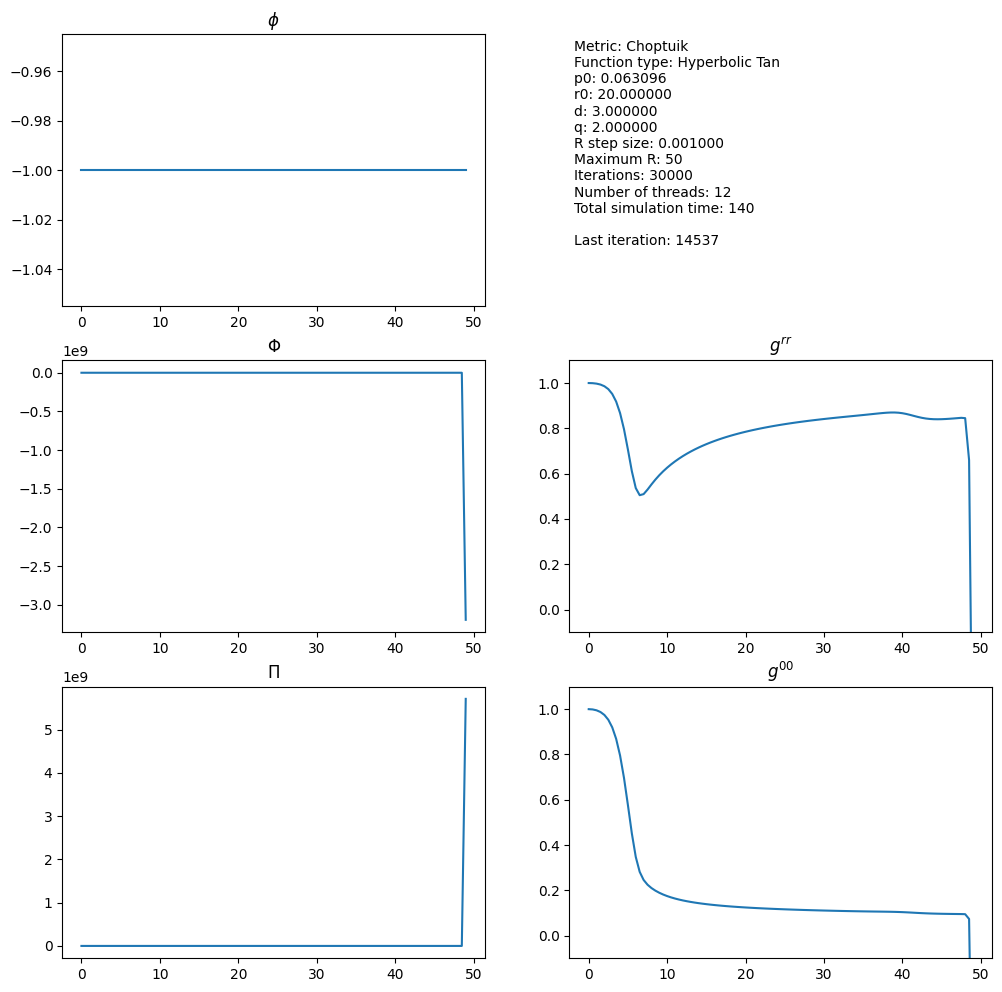

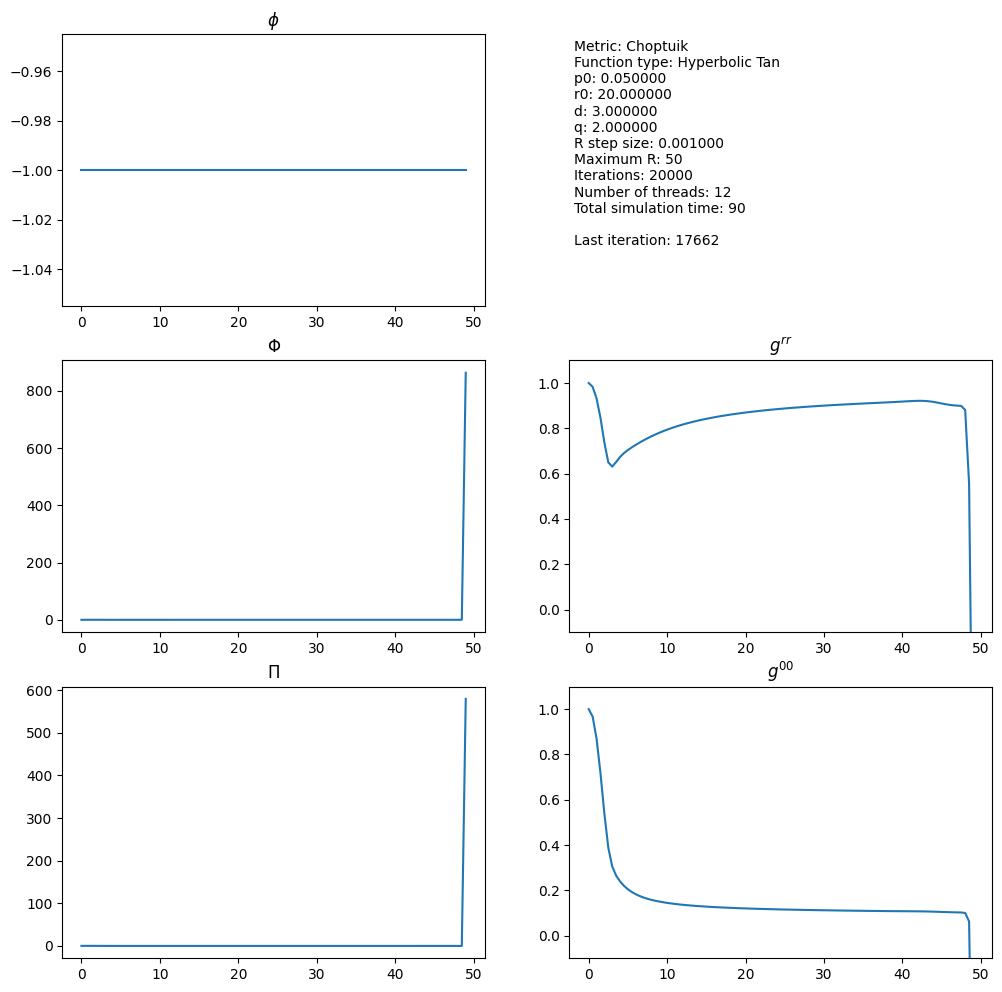

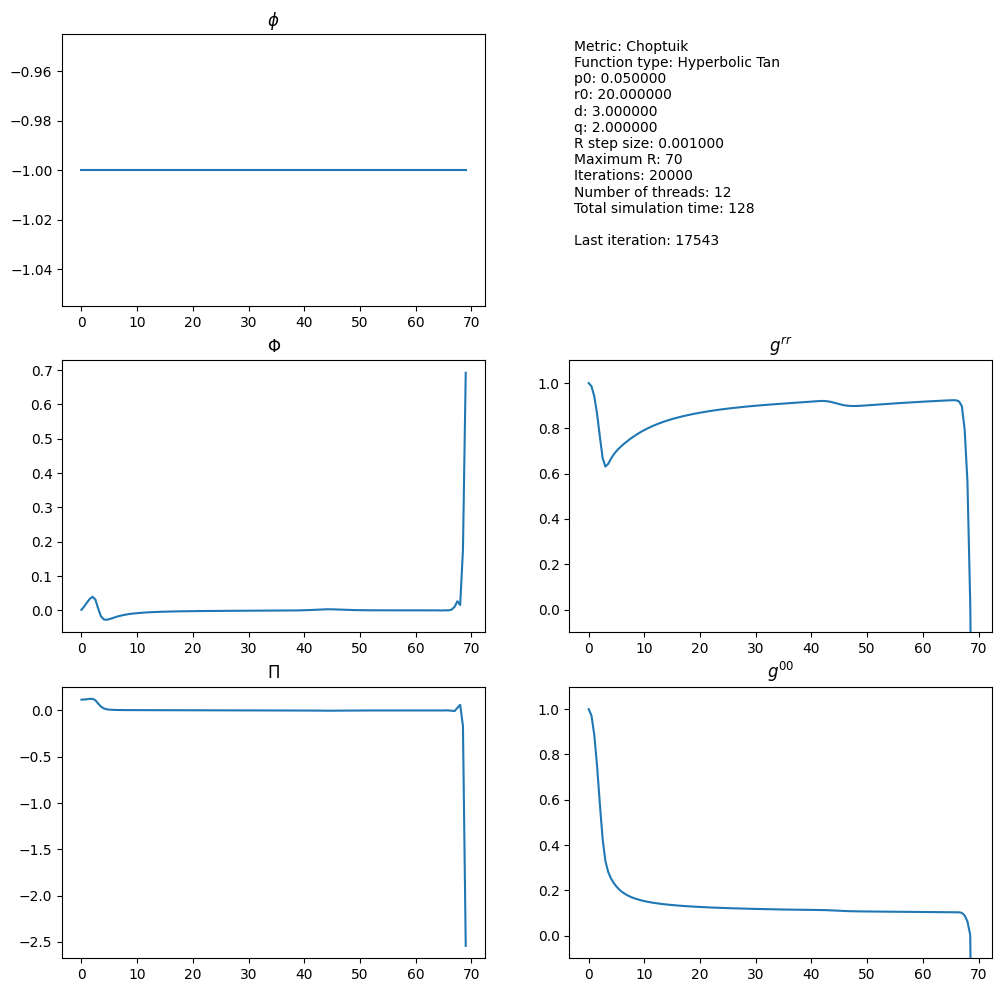

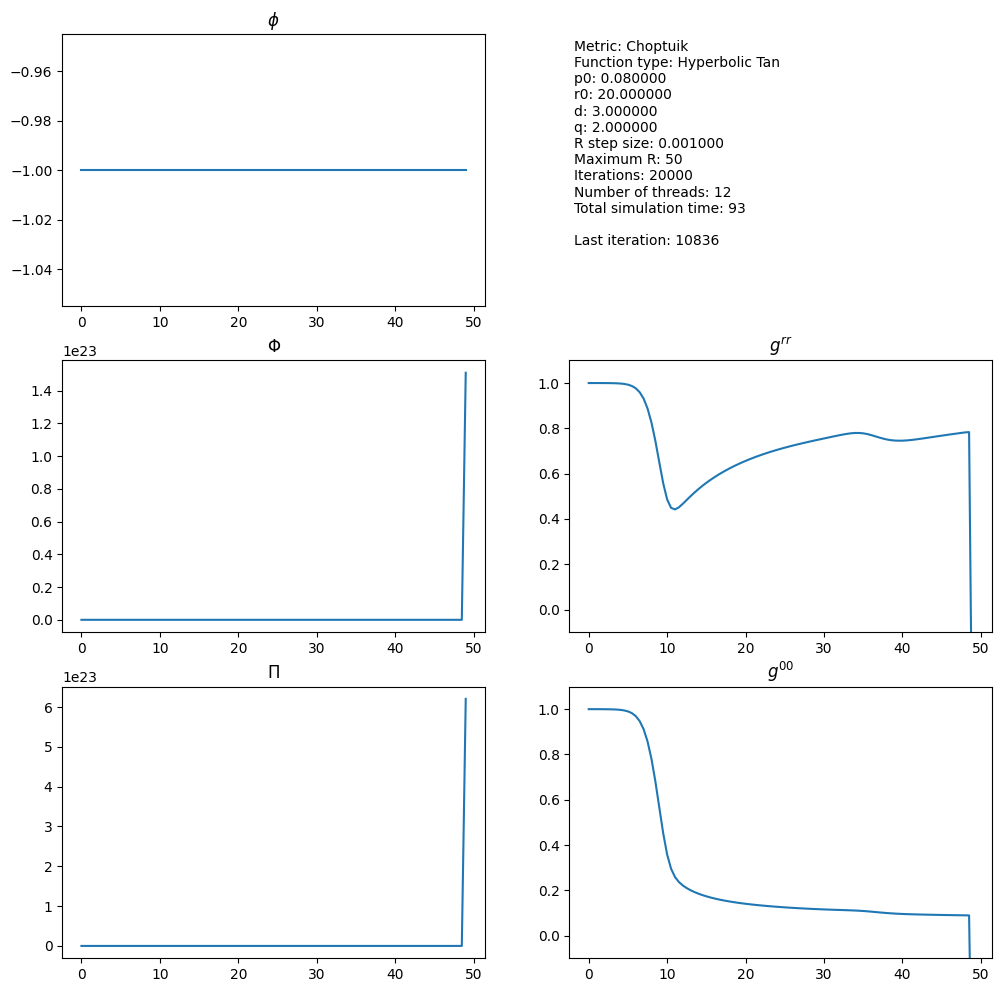

In [33]:
#Read the last runs and print the image before collapse
import pandas as pd
from os import listdir

#Search files
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
for file in folder_files:
    r,f,x,y,a,b,param = read_data(file)
    if param['fType'] == 'Hyperbolic Tan':
        plot_last(file,0)
        plt.show()

In [5]:
#Run for exponential  function

import subprocess
import numpy as np

fType = "1"
p0s = np.array((3.7,5,6,8))*10**(-6)
r0 = "0"
d  = "0"
q  = "0"
iterations = "20000"
maxR = "50"
processes = "0"
for p0 in p0s:
    output = subprocess.check_output([".\Collapse_full.exe", fType, str(p0), r0, d, q, maxR, iterations, processes], text=True,)
    print(f"{output}")

Parallel execution:
Total iterations: 20000
Finished

Parallel execution:
Total iterations: 20000
Finished

Parallel execution:
Total iterations: 20000
Finished

Parallel execution:
Total iterations: 20000
Finished



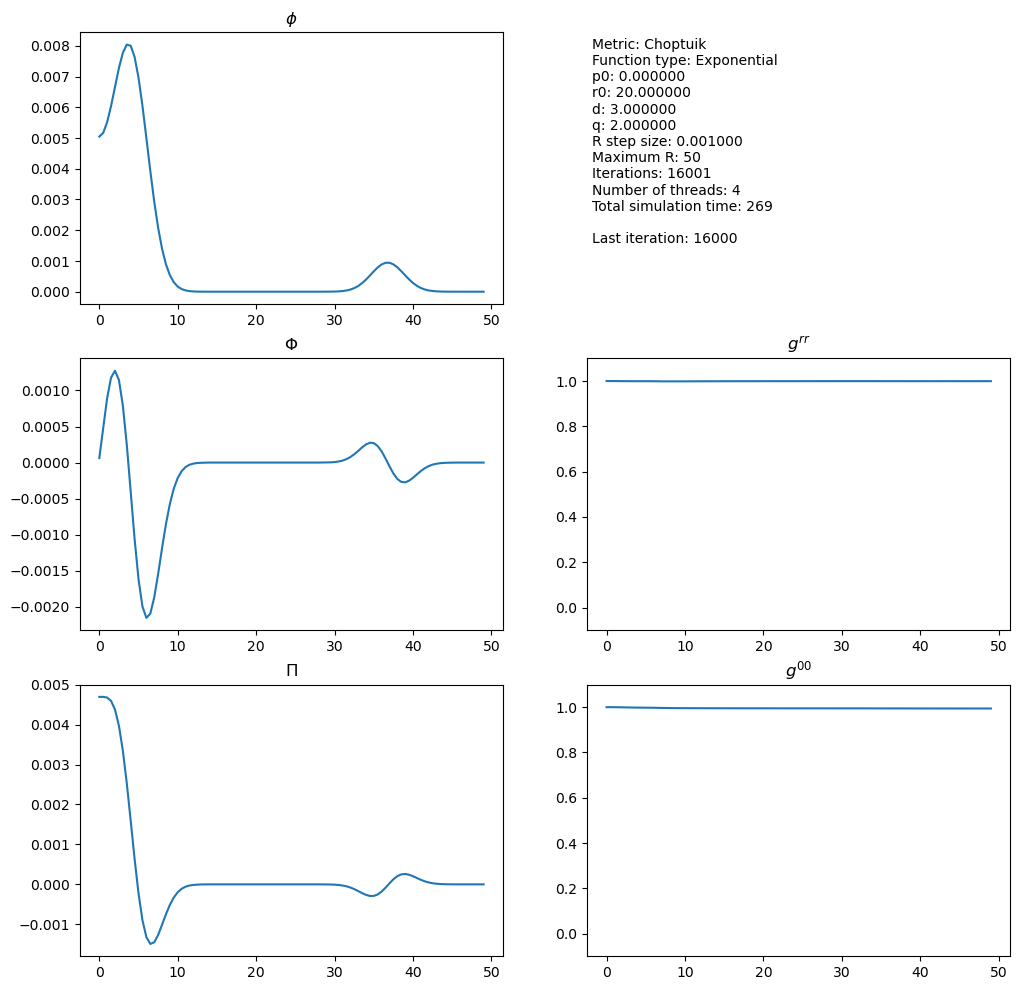

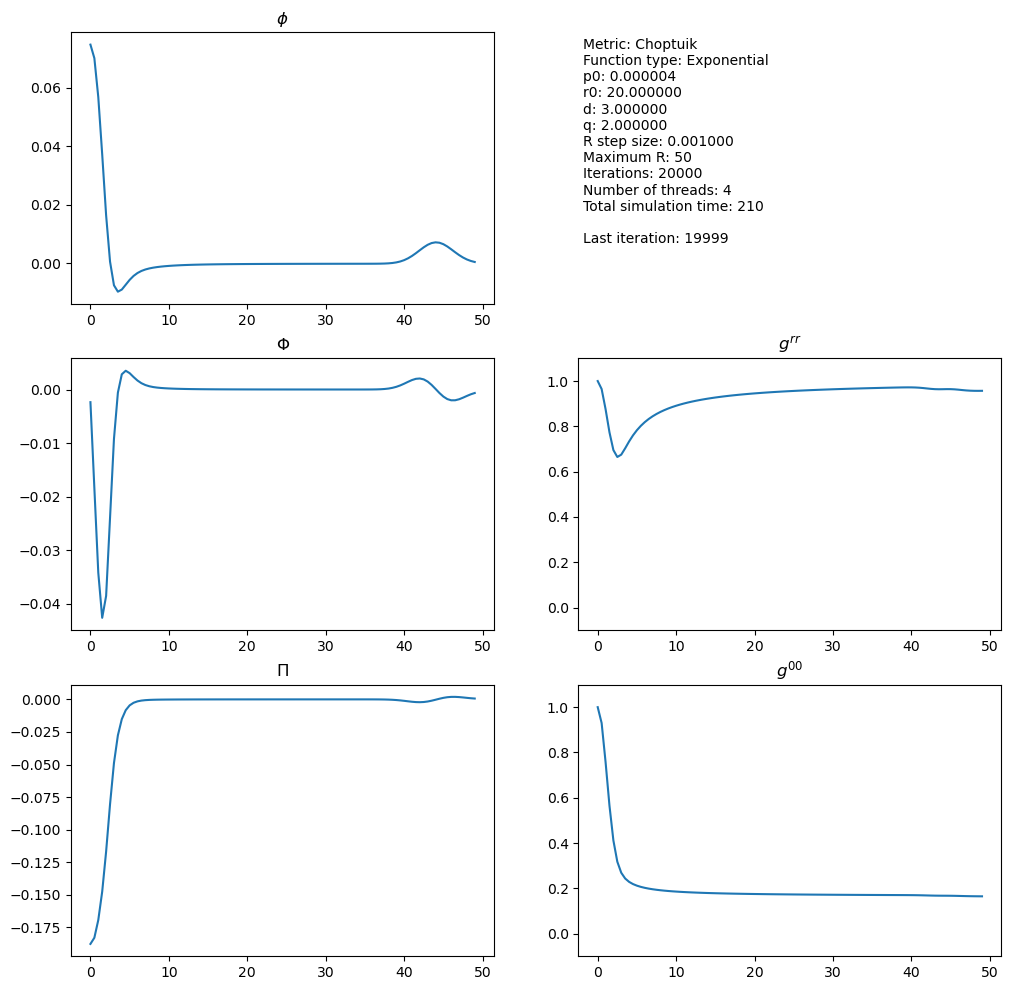

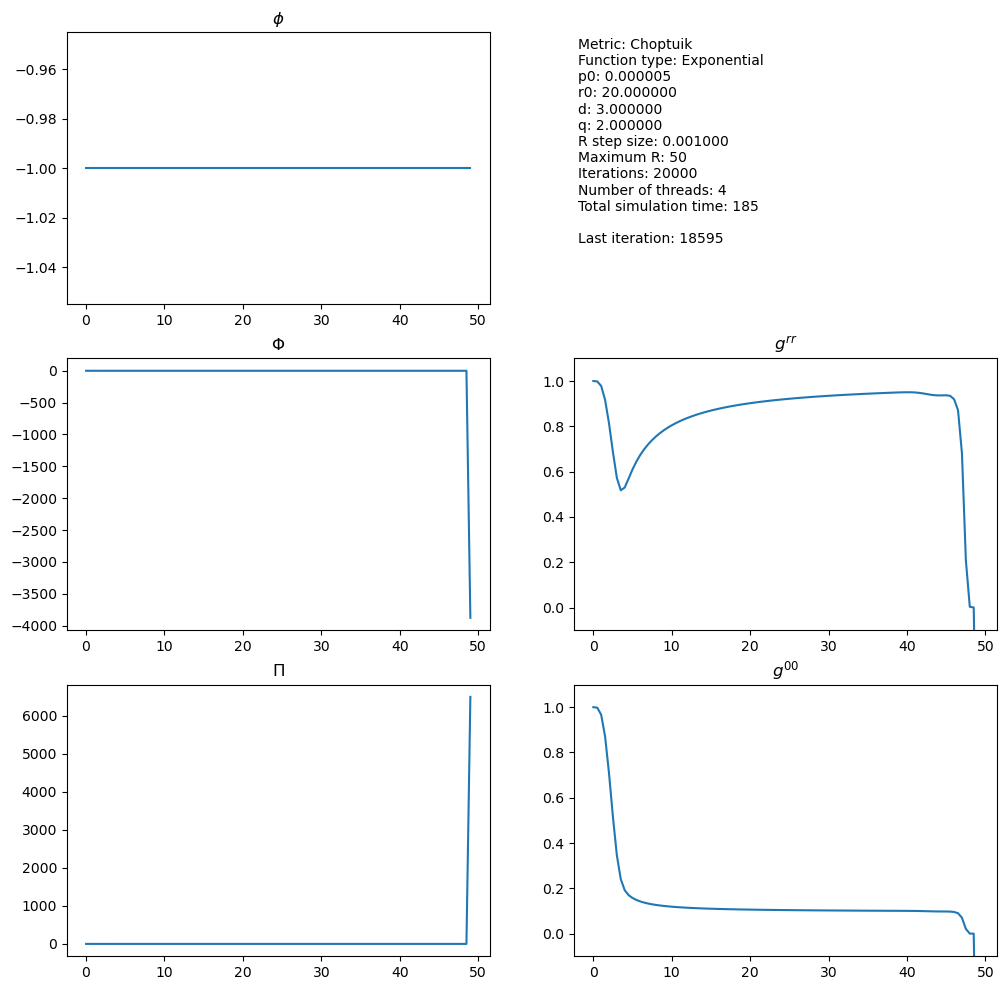

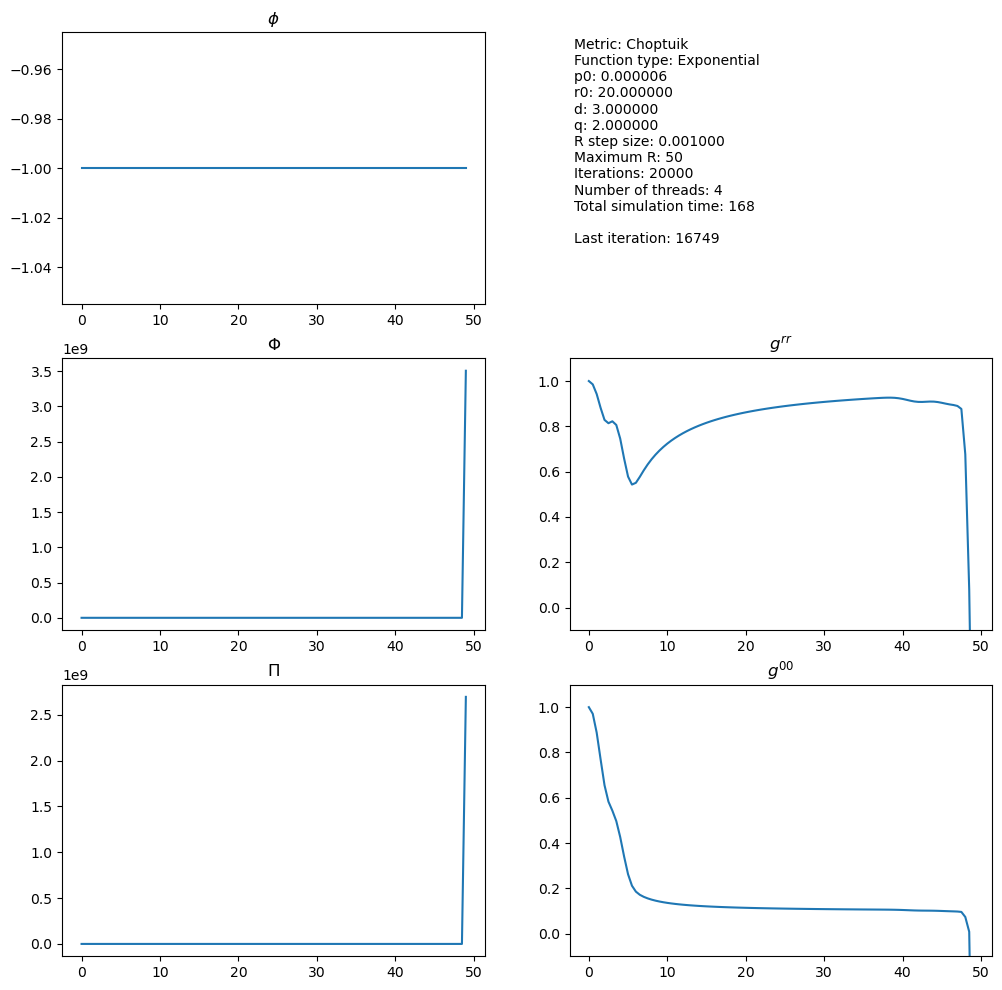

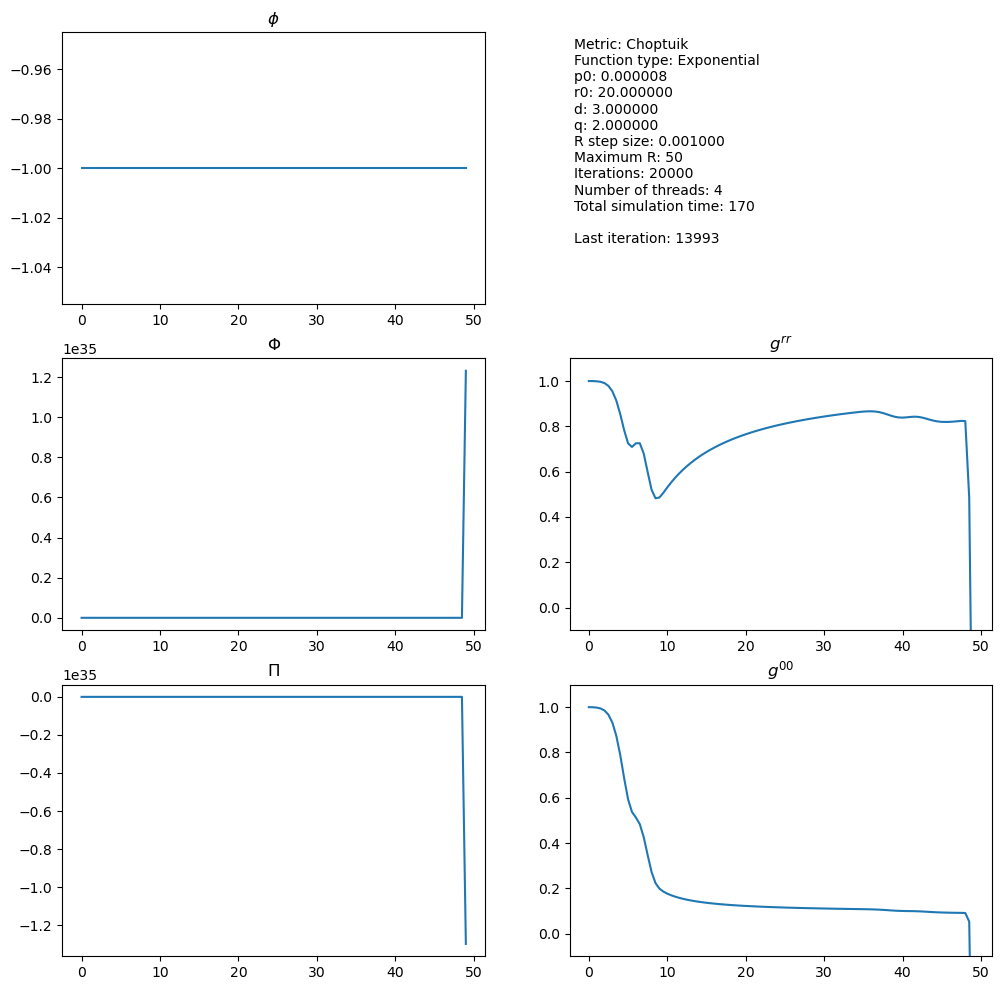

C:\Users\bigba\AppData\Local\Temp\ipykernel_6360\1088094352.py:42: RuntimeWarning: divide by zero encountered in power
  grdata = (np.array(alldata[3*len_5:4*len_5]))**(-2)
C:\Users\bigba\AppData\Local\Temp\ipykernel_6360\1088094352.py:43: RuntimeWarning: divide by zero encountered in power
  g0data = (np.array(alldata[4*len_5:]))**(-2)


In [6]:
#Read the last runs and print the image before collapse
import pandas as pd
from os import listdir

#Search files
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
for file in folder_files:
    r,f,x,y,a,b,param = read_data(file)
    if param['fType'] == 'Exponential':
        plot_last(file,0)
        plt.show()

# Fig 1 replica

In [15]:
#Run the simulation

import subprocess
output = subprocess.check_output([".\Collapse_full.exe", '0', '0.04', '0', '0', '0', '50', '16001'], text=True,)
output = subprocess.check_output([".\Collapse_full.exe", '1', '0.00000016', '0', '0', '0', '50', '11'], text=True,)
print(f"Parallel execution:\n{output}")

Parallel execution:
Total iterations: 11
Finished



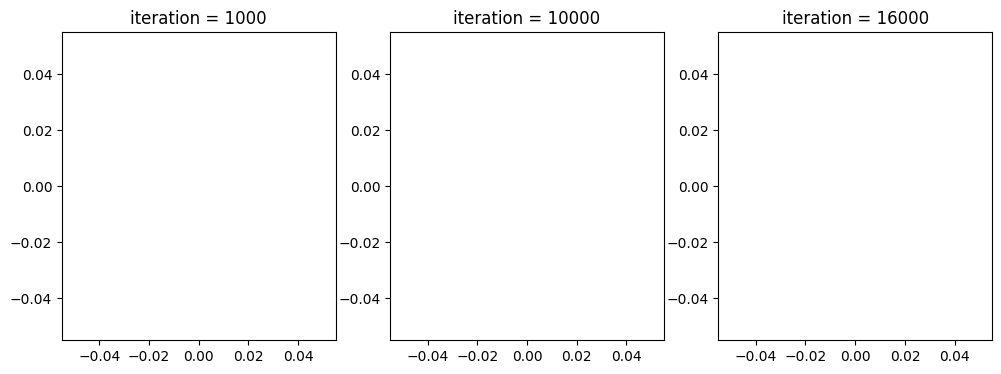

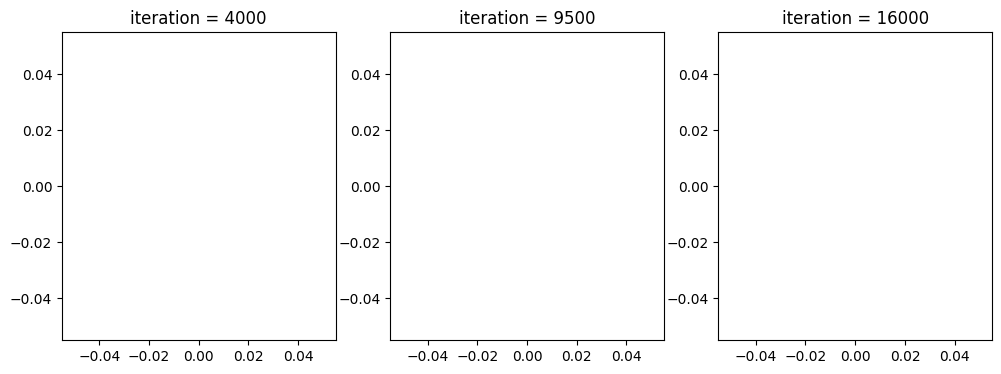

In [6]:
#Plot the phi field at given times

fname = 'Output_232606.dat'
r,f,x,y,a,b,param = read_data(fname)

tanh_times = [1000,10000,16000]
fig, ax = plt.subplots(1,3,figsize=(12,4),dpi=100)
ax[0].plot(r,f[tanh_times[0]])[0]
ax[0].set_title(f'iteration = {tanh_times[0]}')
ax[1].plot(r,f[tanh_times[1]])[0]
ax[1].set_title(f'iteration = {tanh_times[1]}')
ax[2].plot(r,f[tanh_times[2]])[0]
ax[2].set_title(f'iteration = {tanh_times[2]}')
plt.show()

fname = 'Output_232720.dat'
r,f,x,y,a,b,param = read_data(fname)

gaussian_times = [4000,9500,16000]
fig, ax = plt.subplots(1,3,figsize=(12,4),dpi=100)
ax[0].plot(r,f[gaussian_times[0]])[0]
ax[0].set_title(f'iteration = {gaussian_times[0]}')  
ax[1].plot(r,f[gaussian_times[1]])[0]
ax[1].set_title(f'iteration = {gaussian_times[1]}')  
ax[2].plot(r,f[gaussian_times[2]])[0]
ax[2].set_title(f'iteration = {gaussian_times[2]}')  
plt.show()